# Supplementary Notebook for PhD Thesis:
## Title: *Direct and Indirect Energy Flexibility Interactions at the Building and Community Scale: From system to Human-Interfaced Systems


>***First time using a Jupyter Notebook ?*** In order to use this notebook online through the Mybinder public service, click the following icon  
[![Binder](../images/badge_logo.svg)](https://mybinder.org/v2/git/https%3A%2F%2Fgricad-gitlab.univ-grenoble-alpes.fr%2FNanaKofi%2Fpredis_indirect_flexibility/master?labpath=Indirect_flex_assessment.ipynb)  

>You can then easily use this Jupyter notebook by runnning each cell with the Run ("Exécuter" in French) icon in the toolbar on top of the page. When the orange notebook icon in the tab turns into an hourglass, this means the code is still running. Do not hesitate to modify and adapt the code, working with Mybinder creates an online copy of the repository ipynb original file.
    

The goal of this study is to compare a rule based battery control strategy to an optimization based control srategy. 
We consider our experimental setup, Predis-MHI for this purpose.



For all intents and purposes, the diagram below represents the system being evaluated.

### Pictorial view of the building

![green-er.png](../images/green-er.png)

### The energy setup
![fig36.png](../images/fig36.png)

## Data specifications
>### Predis-MHI
|#|Key |Description |
|---|---|---|
| 1 | name |Predis_data_2020_2022.csv | 
| 2 | title |Predis-MHI electricity consumption and production datatsets | 
| 3 | id | |
| 4 | description |dataset containing the demand profiles <br> (building and 4 charging stations) and the solar PV (22kWp) production profiles <br>  collected from the Building Management System of GreEn-ER |
| 5 | language | en-US |
| 6 | subject |Reference the topic of the resource in ontology terms  |
| 7 | keywords |Smart Building, <br>Living Lab,<br>Building energy data] |
| 8 | publicationDate | (2023-07-17) |
| 9 | context |Used in a study to assess the impact of <br> indirect flexiblty on the perfrmance of a building's energy system  |
| 10 | spatial | France  | 
| 11 | temporal |2020-01-01 to 2022-12-31  |
| 12 | source |G2ELab |
| 13 | licenses |CC By 4.0  |
| 14 | contributors |Nana Kofi Twum-Duah, Frederic Wurtz, Stéphane Ploix, Manar Amayri |
| 15 | resources |individual file  |
| 16 | resolution |1 hour | 



### Relevant imports

to run this notebook, the following libraries are required

* pandas Version => 1.2.4
* numpy Version => 1.19.5
* plotly Version => 4.14.1
* Pyomo Version ==  6.0.1

### Note
This note book will not run if you do not install the dependancies, you can do that in the next cell <br>
``os.system('pip install -e .')`` in the next cell is not required if you have already done this in terminal<br>
if you need to install the dependancies, uncomment the entire code block

 

In [1]:
import os

work_path = os.getcwd()
########################################################
# #uncomment to install dependencies
# print (work_path)
# os.chdir("../")


# work_path = os.getcwd()

# print (work_path)

# os.system('pip install -e .')

# os.chdir(f"{work_path}\\notebooks")

# work_path = os.getcwd()

# print (work_path)
##################################################
# os.system('pip install ')
###Necessary for glpk to  work on binder (if not on binder comment out next line)
# os.system('conda install -c conda-forge glpk')

### NOTE

The ``show_plots`` parameter is to allow for the plots to bre rendered in the GitLab repository (GitLab does not render html plots). If you want an interactive notebook set it to ``False`` and rerun the entire notebook.



Alternatively, an HTML version of this notebook is provided in the folder **html_files**

In [2]:
show_plots = True

## Import Libraries

In [3]:
import pandas as pd
import numpy as np
import plotly.express as px
import datetime

from omegalpes.general.optimisation.elements import Quantity
from pulp import PULP_CBC_CMD, GUROBI_CMD
from IPython.display import clear_output
from pulp import *

from tools.assessment_tools import optimization, data_manager

# import time
# import datetime

# import os
# os.makedirs("sites/Predis/LP_files", exist_ok=True)

In [4]:
pv = "production"
demand = "global_consumption"
indirect_flex = ["charger 1" , "charger 2","charger 3" , "charger 4"]
c_impact = "co2"

In [5]:
d_manager = data_manager.DataManager()
optimizer = optimization.Optimize(pv = pv, demand = demand , indirect_flex = indirect_flex )

In [6]:
def predict( start=None, df = None, horizon:int  =24, column=None, dates= False):
    end = start + datetime.timedelta(hours = horizon)
    if end > df.index[-1]:
        end = end - datetime.timedelta(hours = 1)
        if end > df.index[-1]:
            end = df.index[-1]
#     print ("START: ",start)
#     print ("END : ",end)

    if dates:
         return end , df[column].loc[str(start.date())].tolist(), df.loc[str(start.date())].index
    else:

        return end , df[column].loc[str(start.date())].tolist()

In [7]:
predis = pd.read_csv("../data/Predis_data_2020_2022.csv", sep=",", decimal=".", header=0,
                   encoding = "UTF-8",na_values = "NaN")
predis['Datetime']= pd.to_datetime(predis['Datetime'],dayfirst = False)



predis = predis.set_index("Datetime")
predis = predis[predis.index >= '2020-01-01 00:00:00']
predis =predis[predis.index <= '2022-12-31 23:55:00']

predis["global_consumption"] = predis[["charger 1", "charger 2","charger 3","charger 4","Consumption"]].sum(axis = 1)
predis.fillna(0,inplace = True)

# Rule Based Battery control

To serve as a baseline for comparison purposes a simple battery control rule is implemented below with 2 types of control profiles:
   * Load priority: in this control strategy, the load is given priority and as such takes the energy from the PV first and any left overs are sent to the batteries. batteries are discharged to supply energy to the load if need be.
   * Battery Priority: in this strategy, the batteries have priority over the load and as such are served first and any excess presented to the load. discharging only occurs when PV is absent or battery is fully charged and PV is present but insufficient to satisfy the load.
   
  ### Flow chart of rule based approach
![fig35.png](../images/fig35.png)

In [8]:

def battery (capacity:float = 50.0,soc:float=1.0 , prod:float=0.0 , load:float=0.0 , t:int=1, priority:str="load",
             max_dod:float = 0.2 ):
    
    max_chg = 40
    max_dischg = -40
    
    capacity = 50 #kwh
    max_dod = 0.2 #%
    
        
    ch_eff = 0.95
    dis_eff = 0.95
    
    batt = prod - load
    
    if batt >= max_chg:
        
        batt = max_chg/ ch_eff
        
    elif batt < max_dischg:
        
        batt = max_dischg
    
    #Charging
    if batt >= 0:
        
        if soc + (ch_eff * batt / capacity) <= 1:
            soc += (ch_eff * batt / capacity)
            
        else:
            batt = ((1 - soc) * capacity) / ch_eff
            soc = 1
    #discharging
    else:
        if soc + ((batt/dis_eff)/capacity) < max_dod:
            
#             soc += (batt/dis_eff)/capacity
            
#         else:
            batt = -(soc - max_dod) * capacity * dis_eff
            
        soc += (batt/dis_eff)/capacity
        
    
    return soc, batt
            

In [9]:
dates = predis.index

prod =  predis["production"].tolist()
load =  predis["global_consumption"].tolist()

p,l = [],[]

for i in range (24):
    p.append(prod[i])
    l.append(load[i])
soc_current = 1
SOC, batt_power = [soc_current],[]
for i in range(len(prod)):
    soc, batt = battery(soc = soc_current, prod = prod[i], load = load[i])
    SOC.append(soc)
    batt_power.append(batt)
    soc_current = soc
    
    

In [10]:
results = pd.DataFrame({"production" : prod , "consumption" : load,"battery_rb" :batt_power }, index = dates)

results["SOC"] = SOC[:-1]
results["SOC"] *= 10
results["SC_RB"] = np.minimum(results.production - results.battery_rb, results.consumption)
results.index = pd.to_datetime(results.index)
results

production  consumption  battery_rb        SOC  SC_RB
Datetime                                                                  
2020-01-01 00:00:00         0.0          3.0        -3.0  10.000000    3.0
2020-01-01 01:00:00         0.0          1.0        -1.0   9.368421    1.0
2020-01-01 02:00:00         0.0          2.0        -2.0   9.157895    2.0
2020-01-01 03:00:00         0.0          2.0        -2.0   8.736842    2.0
2020-01-01 04:00:00         0.0          1.0        -1.0   8.315789    1.0
...                         ...          ...         ...        ...    ...
2022-12-31 19:00:00         0.0          1.0        -0.0   2.000000    0.0
2022-12-31 20:00:00         0.0          1.0        -0.0   2.000000    0.0
2022-12-31 21:00:00         0.0          0.0         0.0   2.000000    0.0
2022-12-31 22:00:00         0.0          0.0         0.0   2.000000    0.0
2022-12-31 23:00:00         0.0          0.0         0.0   2.000000    0.0

[26304 rows x 5 columns]

## Optimization Based approach

In [11]:
def test(data_treated = None,optimal = None , period = 24 ):
    
    for ind in indirect_flex:
        data_treated[ind] = data_treated[ind] *0
    
    prod = data_treated[pv].tolist()
    load = data_treated[demand].tolist()
    chg_1 = data_treated[indirect_flex[0]].tolist()
    chg_2 = data_treated[indirect_flex[1]].tolist()
    chg_3 = data_treated[indirect_flex[2]].tolist()
    chg_4 = data_treated[indirect_flex[3]].tolist()
    
    dates =  data_treated.index.tolist()

    results = []
#     print (prod)
    for capacity  in optimal:

        max_dis = -0.8 * capacity
        max_chg =  0.8 * capacity
        ch_eff = 0.95 
        dch_eff = 0.95
        max_soc = 1 * capacity
        min_soc = 0.2* capacity
        
        init = capacity * 1

        
        df_ = pd.DataFrame()

        length = int(len(dates)/period)
        if length * period < (len (dates)):
            length += 1
        init_cap = init
        start = dates[0]
        for day in data_treated.resample("1D").sum().index:
            

            

            temp= data_treated.loc[str(day.date())]
#             print (temp[indirect_flex[0]].tolist())
            model,rslt = optimizer.simulate(max_dis = max_dis ,
                            max_chg = max_chg, ch_eff = 0.95,
                            dch_eff = 0.95,solver = "gurobi",
                            max_soc = max_soc, min_soc = min_soc,
                            prodd = temp[pv].tolist(),verbose = True,
                            loadd = temp[demand].tolist(),
                            init_cap = init_cap, sd =0,
                            ch_1 = sum(temp[indirect_flex[0]].tolist()) , 
                            ch_2 = sum(temp[indirect_flex[1]].tolist()),
                            ch_3 = sum(temp[indirect_flex[2]].tolist()) ,
                            ch_4 = sum(temp[indirect_flex[3]].tolist()),
                            datess = temp.index)
            
            rslt.set_index("dates")
            df_ = pd.concat([df_,rslt])
#             df_ = df_.append(rslt)

            init_cap = model.end_cap.value
            clear_output(wait = True)
    



        results.append (df_)
        clear_output(wait = True)


    print ("OPTIMIZATION SUCCESSFULLY COMPLETED")
    return results

In [12]:
predis["co2"] = [0] * len(predis)
df_ = test(data_treated = predis.copy(),optimal = [50] , period = 24 )[0]
df_

OPTIMIZATION SUCCESSFULLY COMPLETED


grid_import  grid_export  battery_in  battery_out  battery_energy  \
0         0.000          0.0         0.0        3.000       50.000000   
1         0.000          0.0         0.0        1.000       46.842105   
2         0.000          0.0         0.0        2.000       45.789474   
3         0.000          0.0         0.0        2.000       43.684211   
4         0.000          0.0         0.0        1.000       41.578947   
..          ...          ...         ...          ...             ...   
19        1.000          0.0         0.0        0.000       11.000000   
20        0.335          0.0         0.0        0.665       11.000000   
21        0.000          0.0         0.0        0.000       10.300000   
22        0.000          0.0         0.0        0.000       10.300000   
23        0.000          0.0         0.0        0.000       10.300000   

    charger_1  charger_2  charger_3  charger_4  battery_power  production  \
0         0.0        0.0        0.0        0.0         -3.000         0.0   
1         0.0        0.0        0.0        0.0         -1.000         0.0   
2         0.0        0.0        0.0        0.0         -2.000         0.0   
3         0.0        0.0        0.0        0.0         -2.000         0.0   
4         0.0        0.0        0.0        0.0         -1.000         0.0   
..        ...        ...        ...        ...            ...         ...   
19        0.0        0.0        0.0        0.0         -0.000         0.0   
20        0.0        0.0        0.0        0.0         -0.665         0.0   
21        0.0        0.0        0.0        0.0         -0.000         0.0   
22        0.0        0.0        0.0        0.0         -0.000         0.0   
23        0.0        0.0        0.0        0.0         -0.000         0.0   

   co2_grid  load               dates  
0      None   3.0 2020-01-01 00:00:00  
1      None   1.0 2020-01-01 01:00:00  
2      None   2.0 2020-01-01 02:00:00  
3      None   2.0 2020-01-01 03:00:00  
4      None   1.0 2020-01-01 04:00:00  
..      ...   ...                 ...  
19     None   1.0 2022-12-31 19:00:00  
20     None   1.0 2022-12-31 20:00:00  
21     None   0.0 2022-12-31 21:00:00  
22     None   0.0 2022-12-31 22:00:00  
23     None   0.0 2022-12-31 23:00:00  

[26304 rows x 14 columns]

In [13]:
results

production  consumption  battery_rb        SOC  SC_RB
Datetime                                                                  
2020-01-01 00:00:00         0.0          3.0        -3.0  10.000000    3.0
2020-01-01 01:00:00         0.0          1.0        -1.0   9.368421    1.0
2020-01-01 02:00:00         0.0          2.0        -2.0   9.157895    2.0
2020-01-01 03:00:00         0.0          2.0        -2.0   8.736842    2.0
2020-01-01 04:00:00         0.0          1.0        -1.0   8.315789    1.0
...                         ...          ...         ...        ...    ...
2022-12-31 19:00:00         0.0          1.0        -0.0   2.000000    0.0
2022-12-31 20:00:00         0.0          1.0        -0.0   2.000000    0.0
2022-12-31 21:00:00         0.0          0.0         0.0   2.000000    0.0
2022-12-31 22:00:00         0.0          0.0         0.0   2.000000    0.0
2022-12-31 23:00:00         0.0          0.0         0.0   2.000000    0.0

[26304 rows x 5 columns]

In [14]:
results["battery_milp"] = df_["battery_power"].tolist()
results["SC_milp"] = np.minimum(results.production - results.battery_milp, results.consumption)

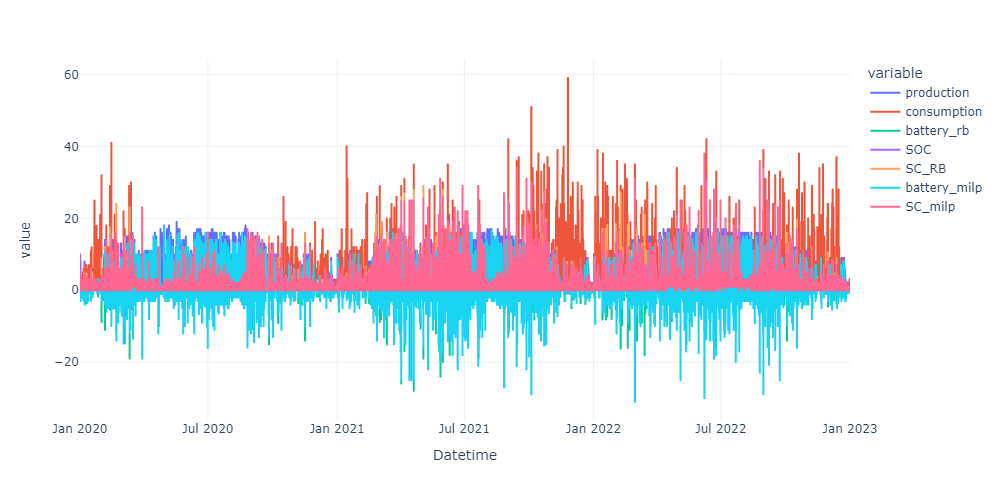

In [15]:
fig = px.line(results.resample("1H").sum(), template = "plotly_white")

if show_plots:

    fig.show("png",width = 1000)
    
else:
    fig.show()

### Annual Self consumption

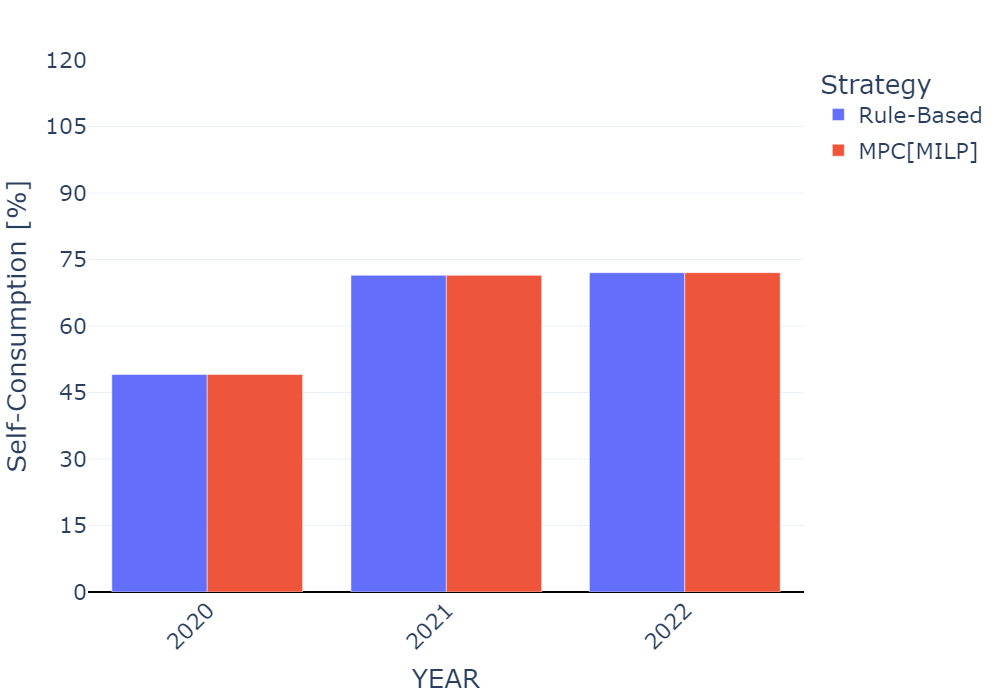

In [16]:
layout = {
   "font":{"size" : 22}, "template": "plotly_white",
    "width" : 1200, "height" : 700,
    'xaxis': {"showline": False,"linecolor": "black", "linewidth": 2,"tickangle" :-45,
              'zerolinecolor':'black',"title_text" : "YEAR","dtick":"M12",
             },
    "yaxis": {"showline": False,"linecolor": "black", "linewidth": 2,
              'zerolinecolor':'black',
               "side": 'left', "dtick" : 15,"range": [0,120],
              "title_text" : "Self-Consumption [%]",

    },
    
    "legend" : {"tracegroupgap":4 ,"font_size": 22,
    "title" : "Strategy"}
}


plotter = results[["SC_RB", "SC_milp","production"]].copy().resample("1Y",label= "left").sum()

# plotter["Self-cons.[OA]"] = plotter["SC_OA"] / plotter["pv"]
plotter["Rule-Based"] = plotter["SC_RB"] / plotter["production"]
plotter["MPC[MILP]"] = plotter["SC_milp"] / plotter["production"]
# plotter["Self-cons.[Pul]"] = plotter["SC_P"] / plotter["production"]

fig = px.bar(plotter [["Rule-Based","MPC[MILP]",]]*100, barmode = "group" )
fig.update_layout(layout)

if show_plots:

    fig.show("png",width = 1000)
    
else:
    fig.show()

### 2020 Montly Self consumption

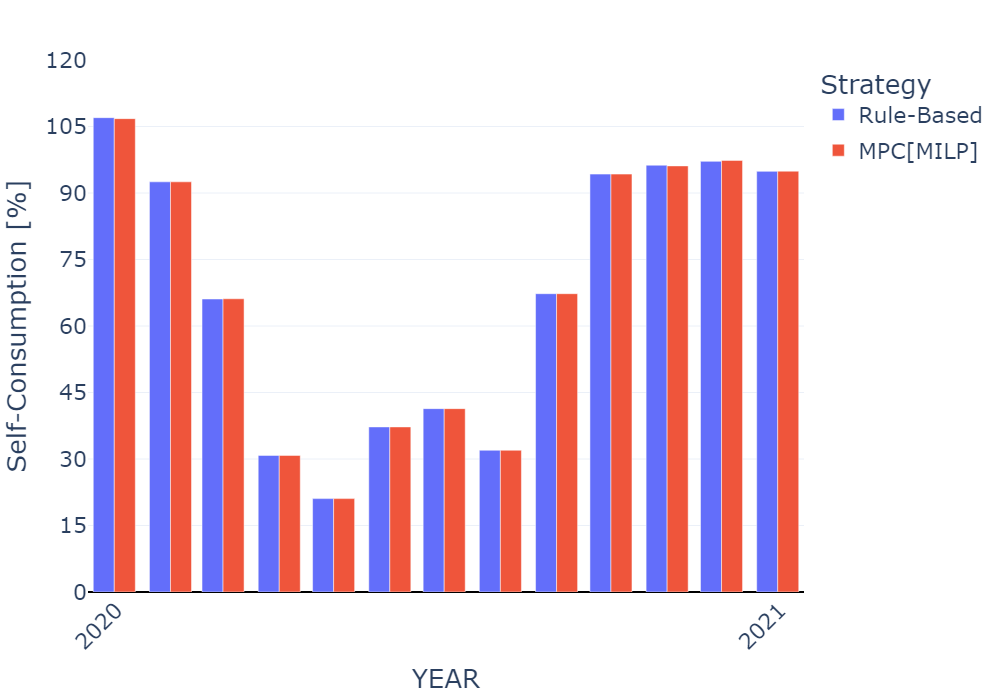

In [17]:
plotter = results[["SC_RB", "SC_milp","production"]].copy().resample("1M",label= "left").sum()

plotter = plotter[plotter.index < "2021-01-01"]

# plotter["Self-cons.[OA]"] = plotter["SC_OA"] / plotter["pv"]
plotter["Rule-Based"] = plotter["SC_RB"] / plotter["production"]
plotter["MPC[MILP]"] = plotter["SC_milp"] / plotter["production"]
# plotter["Self-cons.[Pul]"] = plotter["SC_P"] / plotter["production"]

fig = px.bar(plotter [["Rule-Based","MPC[MILP]",]]*100, barmode = "group" )
fig.update_layout(layout)

if show_plots:

    fig.show("png",width = 1000)
    
else:
    fig.show()

### Comment

Computing the self-consumption on a monthly basis as depicted in in the figure above, the results show that the optimization-based approach does not have a significant advantage over the rule-based approach. The improvements were negligible and did not warrant the complexity or added cost of adopting an optimization-based approach. Thus, it can be inferred that for a problem of similar complexity, a rule-based solution is effective and complex algorithms would not be merited.